# Smart energy forecasting  
## Notebook 3 – Feature engineering 

**Goal:** Transform the cleaned time series into a modeling-ready dataset by creating calendar features, cyclical encodings, lags, and rolling statistics.  

**Input:** `data/energy_france.csv` (from Notebook 1)  
**Output:** `data/features/fr_load_features.csv` (to be used in Notebook 4 – Modeling)



## 1. Load the cleaned dataset

Load the prepared dataset and ensure `datetime` is parsed with the correct timezone (Europe/Paris).


In [69]:

import pandas as pd
import numpy as np

# Load cleaned data
df = pd.read_csv("../data/energy_france.csv", parse_dates=["datetime"])
df["datetime"] = pd.to_datetime(df["datetime"], utc=True).dt.tz_convert("Europe/Paris")
df = df.sort_values("datetime").reset_index(drop=True)

print("Loaded:", df.shape)
print(df.info())
df.head()


Loaded: (50357, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50357 entries, 0 to 50356
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype                       
---  ------    --------------  -----                       
 0   datetime  50357 non-null  datetime64[ns, Europe/Paris]
 1   load_mw   50357 non-null  float64                     
dtypes: datetime64[ns, Europe/Paris](1), float64(1)
memory usage: 787.0 KB
None


,datetime,load_mw
0,2015-01-01 02:00:00+01:00,69773.0
1,2015-01-01 03:00:00+01:00,66417.0
2,2015-01-01 04:00:00+01:00,64182.0
3,2015-01-01 05:00:00+01:00,63859.0
4,2015-01-01 06:00:00+01:00,63921.0



## 2️. Calendar features

We extract basic time-based features that often explain a large portion of demand variance.
- `hour`, `dayofweek`, `is_weekend`  
- `month`, `year` 

**Goal:** Extract simple but highly informative temporal features from the timestamp.

Electricity demand follows clear calendar patterns:
- Hour of day: two daily peaks (morning and evening)
- Day of week: lower consumption during weekends
- Month/season: higher in winter (heating), lower in summer

These features give the model a sense of *when* each observation happens 


In [70]:
# Create calendar features
dt = df["datetime"]

features = pd.DataFrame({
    "datetime": dt,
    "load_mw": df["load_mw"],
    "hour": dt.dt.hour,
    "dayofweek": dt.dt.dayofweek,       # 0= Mon, 6=Sun
    "is_weekend": dt.dt.dayofweek.isin([5,6]).astype(int),
    "month": dt.dt.month,
    "year": dt.dt.year
})

features.head()


,datetime,load_mw,hour,dayofweek,is_weekend,month,year
0,2015-01-01 02:00:00+01:00,69773.0,2,3,0,1,2015
1,2015-01-01 03:00:00+01:00,66417.0,3,3,0,1,2015
2,2015-01-01 04:00:00+01:00,64182.0,4,3,0,1,2015
3,2015-01-01 05:00:00+01:00,63859.0,5,3,0,1,2015
4,2015-01-01 06:00:00+01:00,63921.0,6,3,0,1,2015


**Analysis:** 

The new columns describe when each measurement occurs:
- `hour`: from 0 to 23 (in local French time)
- `dayofweek`: from 0 (Monday) to 6 (Sunday)
- `is_weekend`: binary flag for Saturday/Sunday
- `month` and `year`: seasonal and long-term structure

These features are causal (known ahead of time), so they can safely be used for forecasting.  
They will help the model learn recurring daily and weekly cycles in electricity consumption.


## 3️. Cyclical encodings (sin/cos)

For cyclical variables like hour or month, linear integers are misleading.  
We encode them on the unit circle using `sin`/`cos` so that for example, hour 23 is close to hour 0.

In their raw form:
- `hour = 23` and `hour = 0` look far apart numerically, but they are adjacent in time.
- Same for `month = 12` (December) and `month = 1` (January).

To fix this, we use cyclical encoding.

**Goal:** Represent cyclical time features (like hour, weekday, or month) in a way that preserves their continuity.
This transforms cyclical features into coordinates on a unit circle, 
where close times are geometrically close in feature space.



In [71]:
import numpy as np

def add_cyclical_encoding(df_, col, period):
    df_[f"{col}_sin"] = np.sin(2 * np.pi * df_[col] / period)
    df_[f"{col}_cos"] = np.cos(2 * np.pi * df_[col] / period)
    return df_

# Apply to selected time features
features = add_cyclical_encoding(features, "hour", 24)
features = add_cyclical_encoding(features, "dayofweek", 7)
features = add_cyclical_encoding(features, "month", 12)

# Quick check
features.filter(regex="(_sin|_cos)$").head()


,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,0.500000,8.660254e-01,0.433884,-0.900969,0.5,0.866025
1,0.707107,7.071068e-01,0.433884,-0.900969,0.5,0.866025
2,0.866025,5.000000e-01,0.433884,-0.900969,0.5,0.866025
3,0.965926,2.588190e-01,0.433884,-0.900969,0.5,0.866025
4,1.000000,6.123234e-17,0.433884,-0.900969,0.5,0.866025


**Analysis:** 

These new `sin` and `cos` columns allow the model to correctly interpret cyclical patterns:

- `hour_sin` / `hour_cos` encode the 24-hour day cycle.
- `dayofweek_sin` / `dayofweek_cos` represent the weekly rhythm (weekdays vs. weekends).
- `month_sin` / `month_cos` capture the annual seasonality.

Instead of a sharp numeric jump between the end and start of each cycle (eg, 23 -> 0),
the sine and cosine values ensure a smooth transition.

This technique helps models (especially linear ones) learn periodic behavior more efficiently.


### Visualizing cyclical encodings

To better understand how sinusoidal encodings work, we can plot `hour_sin` vs `hour_cos`.

If the encoding is correct, the points for each hour of the day will form a perfect circle,
showing that hour 0 and hour 23 are right next to each other in the feature space.


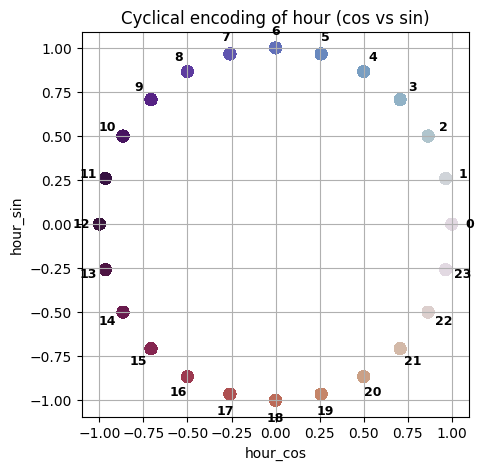

In [76]:
import matplotlib.pyplot as plt

# Visualize the 24-hour cyclical encoding
plt.figure(figsize=(5,5))
plt.scatter(features["hour_cos"], features["hour_sin"], c=features["hour"], cmap="twilight", s=60)

# Annotate with hour numbers (0–23)
for h in range(24):
    # Mean position of each hour (since many rows share the same hour)
    mean_x = features.loc[features["hour"] == h, "hour_cos"].mean()
    mean_y = features.loc[features["hour"] == h, "hour_sin"].mean()
    plt.text(mean_x*1.1, mean_y*1.1, str(h), ha="center", va="center", fontsize=9, fontweight="bold")


plt.title("Cyclical encoding of hour (cos vs sin)", fontsize=12)
plt.xlabel("hour_cos")
plt.ylabel("hour_sin")
plt.axis("equal")
plt.grid(True)
plt.show()


**Analysis:** 
The circle confirms that the cyclical encoding works properly:

- Each point represents an hour of the day (0–23).
- Consecutive hours are smoothly connected around the circle.
- Hour 23 and hour 0 are adjacent, not distant — unlike with plain integer encoding.

This visual proves why sinusoidal encodings are powerful:
they preserve the natural periodicity of time features,
allowing models to better capture daily and seasonal cycles.


## 4. Lag features (autoregressive signals)

**Goal:** Introduce *memory* into the dataset by including past load values as predictors.

Electricity demand at a given hour is often strongly correlated with:
- the previous hour,
- the same hour yesterday,
- the same hour last week

By shifting the target `load_mw` backward in time, we create lag features that let the model learn these dependencies.


In [72]:

for h in [1, 24, 168]:
    features[f"lag_{h}h"] = features["load_mw"].shift(h)

print("Lags created")
features[["datetime","load_mw","lag_1h","lag_24h","lag_168h"]].head(180).tail(5)


Lags created


,datetime,load_mw,lag_1h,lag_24h,lag_168h
175,2015-01-08 09:00:00+01:00,76633.0,76918.0,80546.0,64277.0
176,2015-01-08 10:00:00+01:00,76121.0,76633.0,79801.0,65100.0
177,2015-01-08 11:00:00+01:00,75885.0,76121.0,79494.0,65875.0
178,2015-01-08 12:00:00+01:00,75521.0,75885.0,79036.0,67460.0
179,2015-01-08 13:00:00+01:00,74111.0,75521.0,77255.0,65706.0


**Analysis:** 
Each new column represents a past observation of the load:

| Feature | Meaning | 
|----------|----------|
| `lag_1h` | Load one hour before | 
| `lag_24h` | Load at the same hour the previous day |
| `lag_168h` | Load one week earlier | 

These features are highly predictive, especially for stable systems like electricity demand.  
They introduce temporal dependency without leaking future information (we only use known past values).


### Visualizing the impact of lag features

Let's visualize how the current load relates to its past values.
We will:
- Compare the current load with its previous hour (`lag_1h`) and previous day (`lag_24h`).
- Look at the correlation coefficients between `load_mw` and these lags.

This helps confirm that the electricity demand is highly autocorrelated, 
meaning past consumption is a strong predictor of future consumption.


In [73]:
# Compute simple correlations
lag_corrs = features[["load_mw", "lag_1h", "lag_24h", "lag_168h"]].corr()
print("Correlation between load and its lags:\n")
print(lag_corrs["load_mw"])


Correlation between load and its lags:

load_mw     1.000000
lag_1h      0.980249
lag_24h     0.924935
lag_168h    0.903941
Name: load_mw, dtype: float64


**Analysis:** 
The correlation values should be high and positive (close to 1 for `lag_1h`, 
and still strong for `lag_24h` and `lag_168h`):

- `lag_1h` -> captures short-term continuity (load rarely changes abruptly)
- `lag_24h` -> reflects the daily rhythm (same hour, previous day)
- `lag_168h` -> captures weekly periodicity (same hour, previous week)

High correlation confirms that electricity demand has temporal persistence.


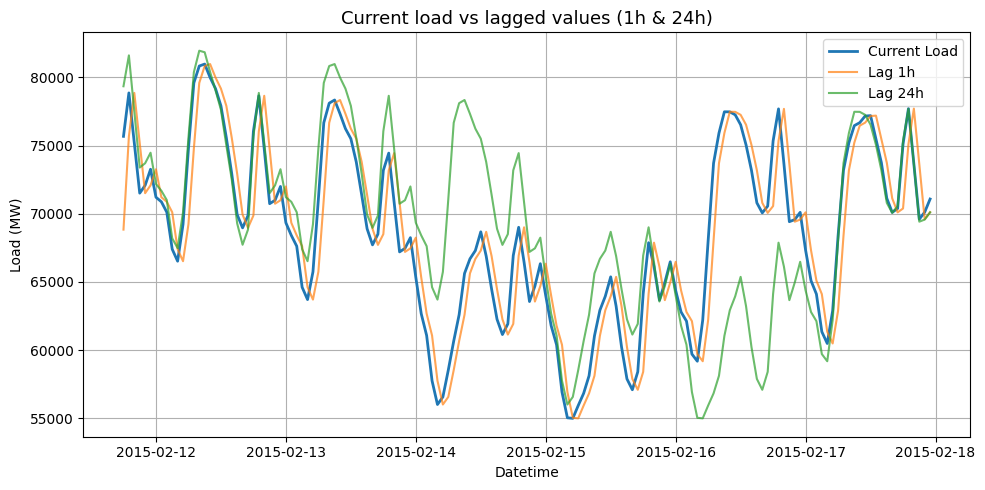

In [77]:
import matplotlib.pyplot as plt

# Select a small time window to visualize the pattern
sample = features.iloc[1000:1150].copy()  # roughly 6 days

plt.figure(figsize=(10,5))
plt.plot(sample["datetime"], sample["load_mw"], label="Current Load", linewidth=2)
plt.plot(sample["datetime"], sample["lag_1h"], label="Lag 1h", alpha=0.7)
plt.plot(sample["datetime"], sample["lag_24h"], label="Lag 24h", alpha=0.7)
plt.title("Current load vs lagged values (1h & 24h)", fontsize=13)
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation of the plot:**  

This visualization clearly highlights the strong temporal structure in the electricity load:

- The blue line (current load) and the orange line (`lag_1h`) almost overlap,
  showing that electricity demand changes very smoothly from one hour to the next.
- The green line (`lag_24h`) follows the same overall shape, 
  with peaks and troughs aligned one day apart, evidence of the strong daily cycle.
- The amplitude difference between `lag_24h` and the current load
  may come from random variations (weather, holidays...).

Overall, this confirms that past consumption is a powerful predictor of current demand.


## 5. Rolling statistics 

**Goal:** Capture short-term and medium-term patterns in electricity demand using moving windows.

While lag features give us exact past values, 
rolling statistics summarize recent history to describe the local trend or stability of the signal.

We will compute:
- Rolling mean (average) -> smooths out short-term fluctuations  
- Rolling standard deviation (std) -> measures local volatility (how much the load varies)

These are useful for models to detect periods of high variability (for example, during weather changes or holidays).

> Note: Rolling windows require sufficient history, so the first rows will be `NaN`.


In [79]:
# Rolling features on 24-hour and 7-day windows
features["roll_mean_24h"] = features["load_mw"].rolling(window=24).mean()
features["roll_std_24h"]  = features["load_mw"].rolling(window=24).std()

features["roll_mean_168h"] = features["load_mw"].rolling(window=168).mean()
features["roll_std_168h"]  = features["load_mw"].rolling(window=168).std()

# Quick check
features[["datetime", "load_mw", "roll_mean_24h", "roll_std_24h"]].head(10)



,datetime,load_mw,roll_mean_24h,roll_std_24h
0,2015-01-01 02:00:00+01:00,69773.0,NaN,NaN
1,2015-01-01 03:00:00+01:00,66417.0,NaN,NaN
2,2015-01-01 04:00:00+01:00,64182.0,NaN,NaN
3,2015-01-01 05:00:00+01:00,63859.0,NaN,NaN
4,2015-01-01 06:00:00+01:00,63921.0,NaN,NaN
5,2015-01-01 07:00:00+01:00,64117.0,NaN,NaN
6,2015-01-01 08:00:00+01:00,63861.0,NaN,NaN
7,2015-01-01 09:00:00+01:00,64277.0,NaN,NaN
8,2015-01-01 10:00:00+01:00,65100.0,NaN,NaN
9,2015-01-01 11:00:00+01:00,65875.0,NaN,NaN


In [80]:
# show features from line 10 to 30

features[["datetime", "load_mw", "roll_mean_24h", "roll_std_24h"]].iloc[10:30, :]



,datetime,load_mw,roll_mean_24h,roll_std_24h
10,2015-01-01 12:00:00+01:00,67460.0,NaN,NaN
11,2015-01-01 13:00:00+01:00,65706.0,NaN,NaN
12,2015-01-01 14:00:00+01:00,62688.0,NaN,NaN
13,2015-01-01 15:00:00+01:00,60798.0,NaN,NaN
14,2015-01-01 16:00:00+01:00,61111.0,NaN,NaN
15,2015-01-01 17:00:00+01:00,65620.0,NaN,NaN
16,2015-01-01 18:00:00+01:00,69967.0,NaN,NaN
17,2015-01-01 19:00:00+01:00,71682.0,NaN,NaN
18,2015-01-01 20:00:00+01:00,70462.0,NaN,NaN
19,2015-01-01 21:00:00+01:00,68173.0,NaN,NaN


**Analysis:** 
Each rolling statistic summarizes recent behavior:
- `roll_mean_24h`: average load over the past 24 hours (captures daily baseline)
- `roll_std_24h`: variability during the last 24 hours
- `roll_mean_168h`: weekly trend (captures slower seasonal drift)
- `roll_std_168h`: variability across the week

These variables act as smoothed signals that help models understand local dynamics.
They are particularly useful when sudden load variations occur (cold spells, holidays, etc).


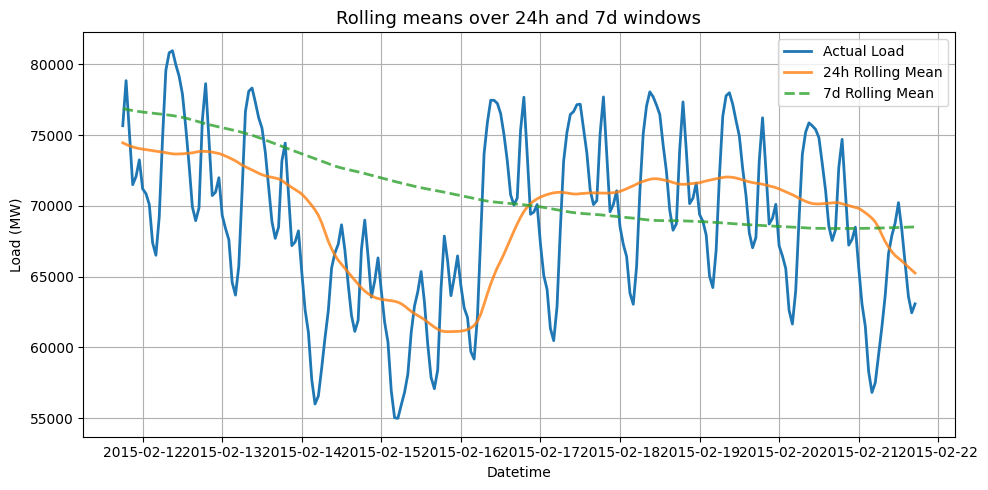

In [81]:
import matplotlib.pyplot as plt

# Select a 10-day window for clarity
sample = features.iloc[1000:1240].copy()

plt.figure(figsize=(10,5))
plt.plot(sample["datetime"], sample["load_mw"], label="Actual Load", linewidth=2)
plt.plot(sample["datetime"], sample["roll_mean_24h"], label="24h Rolling Mean", linewidth=2, alpha=0.8)
plt.plot(sample["datetime"], sample["roll_mean_168h"], label="7d Rolling Mean", linewidth=2, linestyle="--", alpha=0.8)
plt.title("Rolling means over 24h and 7d windows", fontsize=13)
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation of the plot:**  

This chart illustrates how rolling averages smooth out the short-term noise in the electricity load signal:

- The blue line represents the actual hourly consumption, which fluctuates rapidly due to daily activity cycles.
- The orange line (24h rolling mean) captures the short-term trend — it removes most hourly oscillations while following the general daily shape.
- The green dashed line (7d rolling mean) evolves even more smoothly, showing the slower weekly trend that reflects the underlying energy demand level.

Together, these lines show how rolling averages can help a model understand whether the load is currently increasing, stable, or decreasing over time.

In practice, such features make forecasts more stable and robust to short-lived fluctuations.

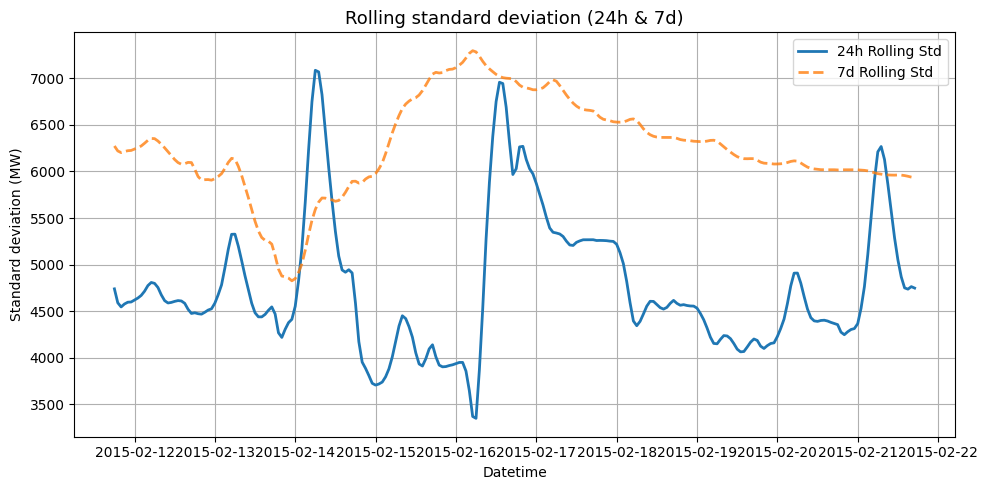

In [82]:
import matplotlib.pyplot as plt

# Select a time slice to visualize volatility
sample = features.iloc[1000:1240].copy()

plt.figure(figsize=(10,5))
plt.plot(sample["datetime"], sample["roll_std_24h"], label="24h Rolling Std", linewidth=2)
plt.plot(sample["datetime"], sample["roll_std_168h"], label="7d Rolling Std", linewidth=2, linestyle="--", alpha=0.8)
plt.title("Rolling standard deviation (24h & 7d)", fontsize=13)
plt.xlabel("Datetime")
plt.ylabel("Standard deviation (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Interpretation of the plot:**  


The rolling standard deviation (`rolling std`) captures the short-term volatility of electricity demand.
It shows how variable the signal is around its recent mean:
high during transitions (morning/evening peaks), 
low during stable periods (night or weekends).

The rolling standard deviation reveals how the load’s variability changes over time:

- The 24h rolling std (blue line) reacts quickly to daily peaks and troughs, 
  highlighting times when demand changes rapidly (morning and evening ramps).
- The 7d rolling std (orange dashed line) evolves more slowly,
  describing broader periods of increased or reduced volatility across the week.

In other words:
- High std values -> unstable periods (rapid demand changes)
- Low std values -> calm, predictable periods

Including these volatility indicators helps the model understand how stable or turbulent the current regime is,  
a key factor for forecasting uncertainty and dynamic behavior.


## 6. Adding french public holidays

**Goal:** Incorporate national holidays as an explanatory feature.

Electricity consumption often drops on public holidays due to reduced industrial and commercial activity.
By flagging these days, we give the model valuable context for unusual load patterns.

We'll use the `holidays` library to automatically generate French public holidays for all years in the dataset.


In [74]:
# Try to import holidays package
try:
    import holidays

    # Create a set of all French public holidays within the dataset range
    years = features["datetime"].dt.year.unique()
    fr_holidays = holidays.France(years=years)
    
    # Flag whether each date is a public holiday
    features["is_holiday"] = pd.to_datetime(features["datetime"].dt.date).isin(fr_holidays).astype(int)
    
    print("Holiday feature successfully created.")
    print(features[["datetime", "is_holiday"]].head(10))

except Exception as e:
    print("Could not add public holidays feature:", e)
    features["is_holiday"] = 0  # fallback


Holiday feature successfully created.
                   datetime  is_holiday
0 2015-01-01 02:00:00+01:00           1
1 2015-01-01 03:00:00+01:00           1
2 2015-01-01 04:00:00+01:00           1
3 2015-01-01 05:00:00+01:00           1
4 2015-01-01 06:00:00+01:00           1
5 2015-01-01 07:00:00+01:00           1
6 2015-01-01 08:00:00+01:00           1
7 2015-01-01 09:00:00+01:00           1
8 2015-01-01 10:00:00+01:00           1
9 2015-01-01 11:00:00+01:00           1


C:\Users\mamyd\AppData\Local\Temp\ipykernel_27824\3323524747.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  features["is_holiday"] = pd.to_datetime(features["datetime"].dt.date).isin(fr_holidays).astype(int)


**Analysis of the `is_holiday` feature:**  

The new column `is_holiday` correctly flags French public holidays with `1`.

Electricity consumption behaves very differently on these days:
- Industrial and office activity is lower (factories, schools, and businesses are closed).
- Residential demand may increase slightly due to people staying at home (heating, cooking, TV).
- The overall effect is a drop in total national load similar to weekends.

By explicitly marking holidays, we prevent the model from interpreting these unusual patterns as random anomalies.

This feature is especially useful for improving forecast accuracy 
around days such as:
- New Year’s Day (1 January),
- Labour Day (1 May),
- Bastille Day (14 July),
- Christmas and other year-end holidays.


## 7. Final cleaning, export

**Goal:** 
1) Remove the initial rows with `NaN` created by lags/rolling windows,  
2) Save the finalized feature matrix to disk for modeling


In [75]:
import os

# 1) Drop rows with any NaN produced by lags/rolling windows
features_final = features.dropna().copy()

print("Final feature table shape:", features_final.shape)
print("Columns:", list(features_final.columns)[:10], "...")  # preview first columns

# 2) Ensure output folder exists and save
os.makedirs("../data/features", exist_ok=True)
out_path = "../data/features/fr_load_features.csv"

# Keep datetime as a column for modeling/plots (not as index)
features_final.reset_index().to_csv(out_path, index=False)
print(f"Saved feature matrix to: {out_path}")


Final feature table shape: (50189, 17)
Columns: ['datetime', 'load_mw', 'hour', 'dayofweek', 'is_weekend', 'month', 'year', 'hour_sin', 'hour_cos', 'dayofweek_sin'] ...
Saved feature matrix to: ../data/features/fr_load_features.csv


We saved a clean, modeling-ready feature matrix as `data/features/fr_load_features.csv`.

This file will be the input of Notebook 04 – Modeling
